In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import TimeDistributed, Dropout, Flatten, Dense, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import gc
import logging
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [22]:
# Define classes
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]

In [23]:
# Check dataset balance
for class_name in classes:
    files = os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{class_name}')
    logging.info(f"{class_name}: {len(files)} videos")

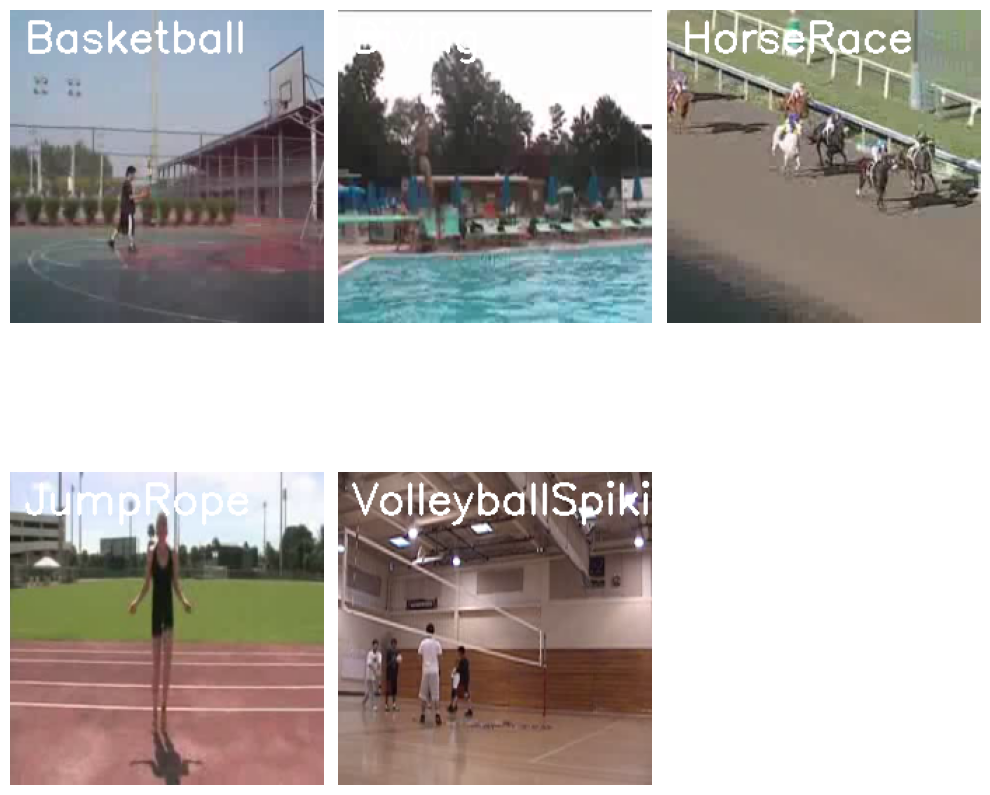

In [24]:
# Visualize sample frames
plt.figure(figsize=(10, 10))
for counter, selected_class_name in enumerate(classes, 1):
    video_files_names_list = os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    if bgr_frame is None:
        logging.warning(f"Failed to read frame from {selected_class_name}/{selected_video_file_name}")
        continue
    bgr_frame = cv2.resize(bgr_frame, (224, 224))
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, counter)
    plt.imshow(rgb_frame)
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.imshow(rgb_frame)
    plt.axis('off')
plt.tight_layout()
plt.show()

sequence_length = 15

In [25]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [26]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        frame = cv2.resize(frame, (224, 224))
        frames_list.append(frame)
    video_reader.release()
    return frames_list


In [27]:
def create_dataset_generator():
    features = []
    labels = []
    for class_name in classes:
        logging.info(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join('/kaggle/input/realistic-action-recognition-ucf50/UCF50', class_name))
        random.shuffle(files_list)
        for file_name in files_list:
            video_file_path = os.path.join('/kaggle/input/realistic-action-recognition-ucf50/UCF50', class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == sequence_length:
                features.append(frames)
                labels.append(class_name)
                if len(features) >= 50:
                    features = np.array(features, dtype=np.float32)
                    labels = np.array(labels)
                    yield features, labels
                    features, labels = [], []
                    gc.collect()
    if features:
        features = np.array(features, dtype=np.float32)
        labels = np.array(labels)
        yield features, labels
    gc.collect()

In [28]:
# Collect dataset with global normalization
X, y = [], []
for batch_features, batch_labels in create_dataset_generator():
    batch_features = batch_features.astype(np.float32)
    # Global normalization (revert to original approach)
    global_mean = np.mean(batch_features)
    global_std = np.std(batch_features)
    batch_features -= global_mean
    batch_features /= (global_std + 1e-7)
    X.append(batch_features)
    y.append(batch_labels)
    gc.collect()

In [29]:
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
logging.info(f"X shape: {X.shape}")

np.save("mean.npy", global_mean)
np.save("std.npy", global_std)

In [30]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
for label in np.unique(y):
    logging.info(f"{label}: {encoder.inverse_transform([label])[0]}")

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
del X, y
gc.collect()


0

In [32]:
xception = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in xception.layers[:-15]:  # Unfreeze more layers for better feature learning
    layer.trainable = False

In [34]:
import tensorflow as tf

In [35]:
model = Sequential([
    TimeDistributed(xception, input_shape=(sequence_length, 224, 224, 3)),
    TimeDistributed(Flatten()),
    LSTM(128, activation="relu", return_sequences=False, dropout=0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(5, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
def data_generator(x_data, y_data, batch_size, datagen):
    num_samples = len(x_data)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_x = x_data[batch_indices]
            batch_y = y_data[batch_indices]
            for i in range(len(batch_x)):
                for j in range(sequence_length):
                    batch_x[i, j] = datagen.random_transform(batch_x[i, j])
            yield batch_x, batch_y

In [37]:
batch_size = 2
train_generator = data_generator(x_train, y_train, batch_size, datagen)
steps_per_epoch = len(x_train) // batch_size

In [38]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [39]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [40]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[es, lr_scheduler],
    verbose=1
)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 284s 525ms/step - accuracy: 0.2513 - loss: 11.0312 - val_accuracy: 0.2044 - val_loss: 12.8239 - learning_rate: 1.0000e-04
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 89s 327ms/step - accuracy: 0.2067 - loss: 12.7323 - val_accuracy: 0.2044 - val_loss: 12.8239 - learning_rate: 1.0000e-04
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 88s 325ms/step - accuracy: 0.1970 - loss: 12.9063 - val_accuracy: 0.2044 - val_loss: 12.8239 - learning_rate: 1.0000e-04
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 88s 326ms/step - accuracy: 0.2118 - loss: 12.4835 - val_accuracy: 0.2263 - val_loss: 11.9308 - learning_rate: 1.0000e-04
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 86s 318ms/step - accuracy: 0.1831 - loss: 13.0350 - val_accuracy: 0.1606 - val_loss: 13.2983 - learning_rate: 1.0000e-04
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 86s 316ms/step - accuracy: 0.1703 - loss: 12.7763 - val_accuracy: 0.3066 - val_loss: 10.9018 - learning_rate: 1.0000e-04
Epoch 7/50
272/272 ━━━━━━━━━━━━━━

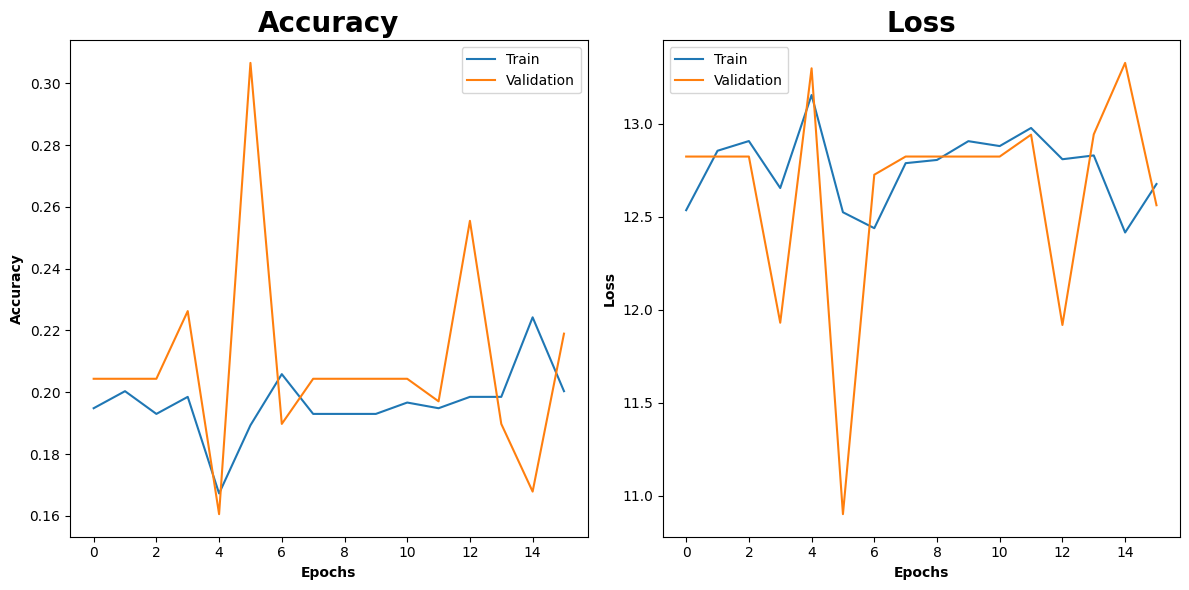

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Accuracy", weight="bold", fontsize=20)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.subplot(1, 2, 2)
plt.title("Loss", weight="bold", fontsize=20)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.tight_layout()
plt.show()


In [42]:
prediction = model.predict(x_test, batch_size=5)
y_hat = np.argmax(prediction, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step 


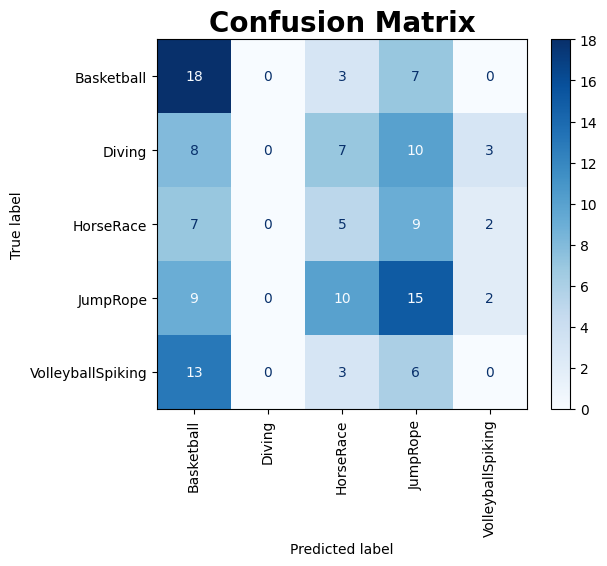

                   precision    recall  f1-score   support

       Basketball       0.33      0.64      0.43        28
           Diving       0.00      0.00      0.00        28
        HorseRace       0.18      0.22      0.20        23
         JumpRope       0.32      0.42      0.36        36
VolleyballSpiking       0.00      0.00      0.00        22

         accuracy                           0.28       137
        macro avg       0.16      0.26      0.20       137
     weighted avg       0.18      0.28      0.22       137



In [43]:
matrix = confusion_matrix(y_test, y_hat)
figure = ConfusionMatrixDisplay(matrix, display_labels=classes)
figure.plot(cmap="Blues")
plt.title("Confusion Matrix", fontsize=20, weight="bold")
plt.xticks(rotation=90)
plt.show()

report = classification_report(y_test, y_hat, target_names=classes)
print(report)

In [44]:
model.save("human_activity_xception_optimized.h5")